In [37]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
!pip install datasets
from datasets import load_dataset

You should consider upgrading via the 'C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\Scripts\python.exe -m pip install --upgrade pip' command.


In [38]:
dataset = load_dataset("google/civil_comments")
print(dataset['train'][0])

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [39]:
print(type(dataset))

<class 'datasets.dataset_dict.DatasetDict'>


In [40]:
# load data 
train_dataset = load_dataset("google/civil_comments", split="train")
print(len(train_dataset['text']))

1804874


In [41]:
# Category names
label_cols = [
    'toxicity', 'severe_toxicity', 'obscene', 'threat', 
    'insult', 'identity_attack', 'sexual_explicit'
]

# Filter data according to the required conditions
def keep_example(example):
    text = example["text"]
    if text.strip() == "":
        return False  # Exclude empty text
    labels = [example[col] for col in label_cols]
    if any(label >= 0.4 for label in labels):
        return True  # Keep if any label >= 0.4
    if all(label == 0.0 for label in labels):
        return True  # Or if they are all zero
    return False  # Exclude the rest

filtered_dataset = train_dataset.filter(keep_example)

print(f"Total after filtering: {len(filtered_dataset)}")
print(filtered_dataset[0])

Total after filtering: 1449483
{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [6]:
# Count the number of rows that contain each label >= 0.4
for label in label_cols:
    count = sum(example[label] >= 0.4 for example in filtered_dataset)
    print(f"{label}: {count}")

toxicity: 201476
severe_toxicity: 75
obscene: 13918
threat: 7749
insult: 151311
identity_attack: 25032
sexual_explicit: 7953


In [7]:
multi_label_count = sum(
    sum(example[label] >= 0.4 for label in label_cols) > 1
    for example in filtered_dataset
)
print(f"Rows with more than one label >= 0.4: {multi_label_count}")


Rows with more than one label >= 0.4: 175269


In [8]:
only_zero_labels = sum(
    all(example[label] == 0.0 for label in label_cols)
    for example in filtered_dataset
)

print(f"Rows with all labels == 0.0: {only_zero_labels}")

Rows with all labels == 0.0: 1242544


In [9]:
exactly_one_label = sum(
    sum(example[label] >= 0.4 for label in label_cols) == 1
    for example in filtered_dataset
)

print(f"Rows with exactly one label >= 0.4: {exactly_one_label}")

Rows with exactly one label >= 0.4: 31670


In [48]:
from datasets import concatenate_datasets, Dataset
import random

max_samples_per_label = 10000
min_required = 7500

# Collect samples by each label
label_datasets = []

for label in label_cols:
    # Samples with this label >= 0.4
    subset = filtered_dataset.filter(lambda example: example[label] >= 0.4)
    
    if len(subset) < min_required:
        print(f"Skipping '{label}' — only {len(subset)} samples.")
        continue
    
    selected = subset.shuffle(seed=42).select(range(min(len(subset), max_samples_per_label)))
    print(f"Label '{label}': {len(selected)} samples selected.")
    label_datasets.append(selected)

# Merge all datasets from toxic categories
toxic_combined = concatenate_datasets(label_datasets)
print(f"\ntoxic_combined dataset size: {len(toxic_combined)}")

✅ Label 'toxicity': 10000 samples selected.
❌ Skipping 'severe_toxicity' — only 75 samples.
✅ Label 'obscene': 10000 samples selected.
✅ Label 'threat': 7749 samples selected.
✅ Label 'insult': 10000 samples selected.
✅ Label 'identity_attack': 10000 samples selected.
✅ Label 'sexual_explicit': 7953 samples selected.

🎯 toxic_combined dataset size: 55702


In [49]:
import pandas as pd
from datasets import Dataset

# Convert to DataFrame
df = toxic_combined.to_pandas()

# Remove duplicates
df = df.drop_duplicates(subset='text')

# Convert to Dataset again
toxic_combined = Dataset.from_pandas(df) 
toxic_combined = toxic_combined.shuffle(seed=42)

print(f"\nToxic dataset (after merging and deduplication): {len(toxic_combined)} samples")


🧪 Toxic dataset (after merging and deduplication): 50011 samples


In [50]:
# Select the same number of clean examples.
neutral_dataset = filtered_dataset.filter(lambda example: all(example[label] == 0.0 for label in label_cols))
neutral_balanced = neutral_dataset.shuffle(seed=42).select(range(len(toxic_combined)))

print(f"Neutral dataset: {len(neutral_balanced)} samples")

# Data merge and randomize
final_balanced = concatenate_datasets([toxic_combined, neutral_balanced]).shuffle(seed=42)
print(f"\nFinal balanced dataset size: {len(final_balanced)}")

✅ Neutral dataset: 50011 samples

🎯 Final balanced dataset size: 100022


In [51]:
import matplotlib.pyplot as plt

label_counts = {}

for label in label_cols:
    count = filtered_dataset.filter(lambda example: example[label] >= 0.4).num_rows
    label_counts[label] = count

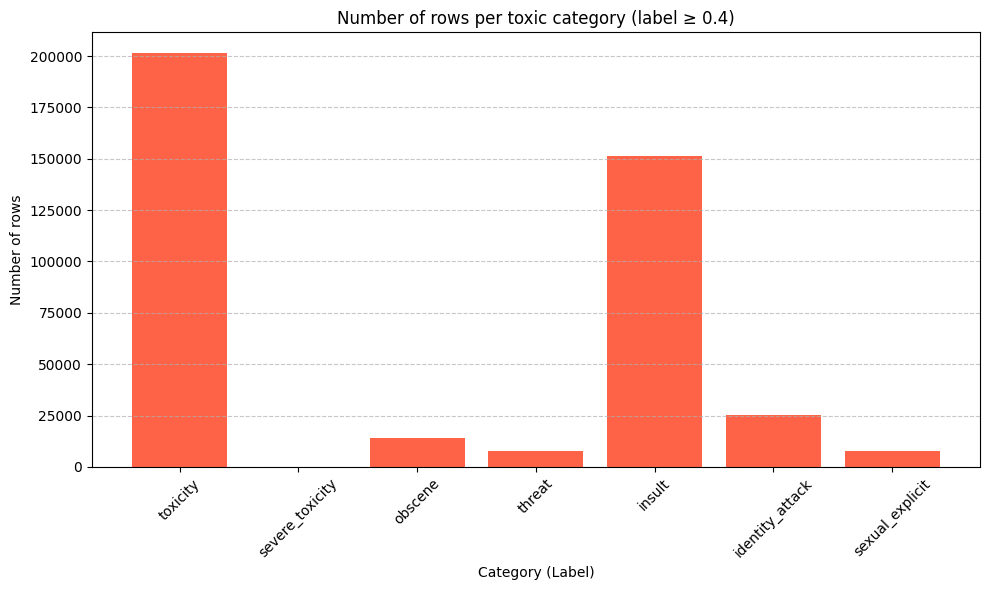

In [52]:
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='tomato')
plt.title('Number of rows per toxic category (label ≥ 0.4)')
plt.xlabel('Category (Label)')
plt.ylabel('Number of rows')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
from datasets import concatenate_datasets

# 1. Exclude rows that contain more than one label ≥ 0.4
def has_only_one_label(example):
    return sum(example[label] >= 0.4 for label in label_cols) == 1

def has_multiple_labels(example):
    return sum(example[label] >= 0.4 for label in label_cols) > 1

single_label_dataset = filtered_dataset.filter(has_only_one_label)
multi_label_dataset = filtered_dataset.filter(has_multiple_labels)

print(f"Single-label rows: {len(single_label_dataset)}")
print(f"Multi-label rows: {len(multi_label_dataset)}")

# 2. Determine the column that contains the only label (primary_label)
def assign_primary_label(example):
    for label in label_cols:
        if example[label] >= 0.4:
            example["primary_label"] = label
            break
    return example

single_label_dataset = single_label_dataset.map(assign_primary_label)


balanced_subsets = []
max_per_class = 7500  

for label in label_cols:
    subset = single_label_dataset.filter(lambda x: x["primary_label"] == label)
    if len(subset) >= max_per_class:
        subset = subset.shuffle(seed=42).select(range(max_per_class))
        balanced_subsets.append(subset)
        print(f"Selected {len(subset)} rows for label: {label}")
    else:
        print(f"Skipped {label} — only {len(subset)} available (< {max_per_class})")

# 3. Merge balanced data with multi-label
balanced_dataset = concatenate_datasets(balanced_subsets + [multi_label_dataset])
print(f"\nFinal balanced dataset size: {len(balanced_dataset)}")


Single-label rows: 31670
Multi-label rows: 175269
Selected 7500 rows for label: toxicity
⚠️ Skipped severe_toxicity — only 0 available (< 7500)
⚠️ Skipped obscene — only 205 available (< 7500)
⚠️ Skipped threat — only 220 available (< 7500)
⚠️ Skipped insult — only 2758 available (< 7500)
⚠️ Skipped identity_attack — only 1418 available (< 7500)
⚠️ Skipped sexual_explicit — only 818 available (< 7500)

✅ Final balanced dataset size: 182769


In [11]:
print(balanced_dataset)

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'primary_label'],
    num_rows: 182769
})


In [12]:
# Clean the texts :
import re

def clean_text(example):
    text = example["text"].lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return {"text": text}

# Apply cleaning using .map() on the full dataset
balanced_dataset = balanced_dataset.map(clean_text)

Map:   0%|          | 0/182769 [00:00<?, ? examples/s]

In [13]:
# Remove empty and null text
cleaned_dataset = balanced_dataset.filter(lambda x: x["text"] not in ["", None])

# Check data size after cleaning
print(f"Number of rows after cleaning: {len(cleaned_dataset)}")

Filter:   0%|          | 0/182769 [00:00<?, ? examples/s]

Number of rows after cleaning: 182769


In [14]:
cleaned_dataset.save_to_disk("cleaned_balanced_civil_comments22")

Saving the dataset (0/1 shards):   0%|          | 0/182769 [00:00<?, ? examples/s]

In [15]:
positive_dataset = cleaned_dataset.filter(
    lambda example: any(example[label] >= 0.5 for label in label_cols)
)
print(f"positive_dataset: {len(positive_dataset)}")

Filter:   0%|          | 0/182769 [00:00<?, ? examples/s]

positive_dataset: 144307


In [16]:
print(positive_dataset[200])

{'text': 'big city departments are just corrupt', 'toxicity': 0.5, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.30000001192092896, 'identity_attack': 0.10000000149011612, 'sexual_explicit': 0.0, 'primary_label': 'toxicity'}


In [17]:
df = pd.DataFrame(cleaned_dataset)
df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,primary_label
0,sherrilyn ifill makes some assumptions that i ...,0.5,0.0,0.0,0.0,0.2,0.3,0.0,toxicity
1,republicans and the nra have done a good job o...,0.4,0.0,0.0,0.1,0.3,0.0,0.0,toxicity
2,i think biased is better as you have before y...,0.5,0.0,0.0,0.0,0.1,0.0,0.2,toxicity
3,if the right wants to actively pass laws again...,0.5,0.0,0.0,0.0,0.3,0.3,0.0,toxicity
4,yes this and the temporary foreign worker scam...,0.4,0.1,0.0,0.0,0.3,0.3,0.0,toxicity


In [18]:
# Check null or None
print("Null or None values:")
print(df.isnull().sum())

# Check only empty text in the text column
print("\nEmpty string values in 'text':")
print((df["text"] == "").sum())

Null or None values:
text                    0
toxicity                0
severe_toxicity         0
obscene                 0
threat                  0
insult                  0
identity_attack         0
sexual_explicit         0
primary_label      175269
dtype: int64

Empty string values in 'text':
0


In [19]:
# lables
labels = df[df.columns[1:]].values

# texts
texts = df['text'].astype(str).values

In [20]:
print(type(texts))
print(texts.shape)

<class 'numpy.ndarray'>
(182769,)


In [21]:
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(182769, 8)


In [22]:
is_empty_string = df['text'] == ''
count_empty_string = is_empty_string.sum()
print("Number of values ​​that equal an empty string:", count_empty_string)

Number of values ​​that equal an empty string: 0


In [23]:
df['text'].isnull().sum()

np.int64(0)

In [24]:
filtered_texts = []
filtered_labels = []

for text, label in zip(texts, labels):
    if text.strip():  
        filtered_texts.append(text)
        filtered_labels.append(label)

texts = filtered_texts
labels = filtered_labels

In [25]:
MAX_WORDS=20000

In [26]:
vectorizer = TextVectorization(
    max_tokens=MAX_WORDS,
    output_sequence_length=300,  
    output_mode='int'
)

vectorizer.adapt(texts)

In [27]:
# Convert data to Dataset
dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

dataset = dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(10000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

ValueError: Can't convert Python sequence with mixed types to Tensor.

In [ ]:
len(dataset)

In [ ]:
# Split into train / val / test
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Input(shape=(300,)))
# Create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(7, activation='sigmoid'))

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)



In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [ ]:
history = model.fit(train, 
                    epochs=6, 
                    validation_data=val,
                    batch_size=32,
                    callbacks=[early_stop]       
                   )

In [ ]:
model.save('Blanced_model04.keras')
print("model saved successfully!")

In [ ]:
import numpy as np

X_val = []
y_val = []

for batch in val:
    features, labels = batch
    X_val.append(features)
    y_val.append(labels)

y_val = np.concatenate([y.numpy() for y in y_val], axis=0)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

y_true = []
for batch in val:
    _, labels = batch
    y_true.append(labels)

y_true = np.concatenate([y.numpy() for y in y_true], axis=0)

y_true_binary = (y_true >= 0.5).astype(int)

y_true = np.vstack([labels.numpy() for _, labels in val])
y_pred_binary = (y_pred >= 0.5).astype(int)

for i, label in enumerate(label_names):
    print(f"\nConfusion Matrix for '{label}':")
    cm = confusion_matrix(y_true_binary[:, i], y_pred_binary[:, i])
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

print("\nClassification Report:")
print(classification_report(
                            y_true_binary,
                            y_pred_binary,
                            target_names=label_names,
                            zero_division=0,
                            labels=[0, 1]  
                            ))


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in val:
    X_true, y_true = batch
    
    yhat = model(X_true, training=False)
    
    y_true_binary = tf.cast(y_true >= 0.5, tf.float32)
    yhat_binary = tf.cast(yhat >= 0.5, tf.float32)

    pre.update_state(y_true_binary, yhat_binary)
    re.update_state(y_true_binary, yhat_binary)
    acc.update_state(y_true_binary, yhat_binary)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


In [ ]:
import numpy as np

all_labels = []
for _, y in val:
    all_labels.append(y.numpy())
all_labels = np.concatenate(all_labels)

print("Positive samples:", np.sum(all_labels))
print("Negative samples:", len(all_labels) - np.sum(all_labels))

In [ ]:
for batch in val.take(1):
    X_true, y_true = batch
    yhat = model.predict(X_true)
    print("Predictions:", yhat[:10].flatten())
    print("Actual labels:", y_true[:10].numpy().flatten())